# (84100) Farnocchia orbit determination test

#### Let's start by importing the necessary libraries

In [1]:
from grss import fit
import numpy as np
np.set_printoptions(precision=40, linewidth=np.inf)

#### We'll then retrieve the cometary state of the asteroid (from JPL SBDB) plus any nongravitational accelerations acting on it.

In [2]:
body_id = '84100'
init_sol, init_cov, nongrav_info = fit.get_sbdb_info(body_id)
de_kernel = 440

#### Next, we'll retrieve the observations from different sources (MPC, JPL, Gaia Data Releases) and prepare them for the orbit determination process.

In [3]:
add_gaia_obs = True
optical_obs_file = None
t_min_tdb = None
t_max_tdb = None
debias_lowres = True
deweight = True
eliminate = False
num_obs_per_night = 4
verbose = True
obs_df = fit.get_optical_obs(body_id, optical_obs_file, t_min_tdb, t_max_tdb, debias_lowres, deweight, eliminate, num_obs_per_night, verbose)
obs_df = fit.add_radar_obs(obs_df, t_min_tdb, t_max_tdb, verbose)
if add_gaia_obs:
    gaia_dr = 'gaiafpr'
    obs_df = fit.add_gaia_obs(obs_df, t_min_tdb, t_max_tdb, gaia_dr, verbose)

Read in 1066 observations from the MPC.
	Filtered to 1066 observations that satisfy the time range and accepted observatory constraints.
Applying Eggl et al. (2020) debiasing scheme to the observations.
	Unknown star catalog: UNK
	No debiasing needed for 628 observations.
	Debiased 416 observations.
	No bias information for 22 observations.
Applying Vereš et al. (2017) weighting scheme to the observations.
	Using 987 CCD observations with station-specific weight rules.
Applying sqrt(N/4) deweighting scheme.
	Deweighted 170 observations.
Read in 191 Gaia observations from gaiafpr
	Filtered to 191 observations that satisfy the time range constraints.


#### All we need to do now is initialize the OD simulation and run the filter.

In [4]:
n_iter_max = 10
fit_sim = fit.FitSimulation(init_sol, obs_df, init_cov, n_iter_max=n_iter_max, de_kernel=de_kernel, nongrav_info=nongrav_info)

In [5]:
fit_sim.filter_lsq()

Iteration		Unweighted RMS		Weighted RMS 		Chi-squared		Reduced Chi-squared
1			 0.390			 0.560			 787.444			 0.314
2			 0.390			 0.559			 786.914			 0.314
Converged without rejecting outliers. Starting outlier rejection now...
3			 0.370			 0.531			 707.921			 0.283
4			 0.369			 0.530			 707.148			 0.283
Converged after rejecting outliers. Rejected 5 out of 1257 optical observations.


#### Let's print some summary statistics and plot some results.

In [6]:
fit_sim.print_summary()

Summary of the orbit fit calculations after postfit pass:
RMS unweighted: 0.3694610011435285
RMS weighted: 0.5303623380450632
chi-squared: 707.1485029761974
reduced chi-squared: 0.28308586988638806
square root of reduced chi-squared: 0.5320581452119572
--------------------------------------------------------------
Solution Time: MJD 58293.000 TDB = 2018-06-24 00:00:00.000 TDB
Solution Observation Arc: 10856.90 days (29.72 years)
--------------------------------------------------------------
Fitted Variable		Initial Value			Uncertainty			Fitted Value			Uncertainty			Change				Change (sigma)
e			2.02454518255e-01		1.40679721887e-09		2.02454518317e-01		1.41317936275e-09		+6.20919426986e-11		+0.044
q			2.17771395357e+00		4.95647771455e-09		2.17771395471e+00		4.98708759091e-09		+1.13493747733e-09		+0.228
tp			5.90657522397e+04		1.11963525625e-05		5.90657522433e+04		1.12644341736e-05		+3.57469252776e-06		+0.317
om			1.52352438968e+02		1.14823095924e-06		1.52352438978e+02		1.16994825639e-06		

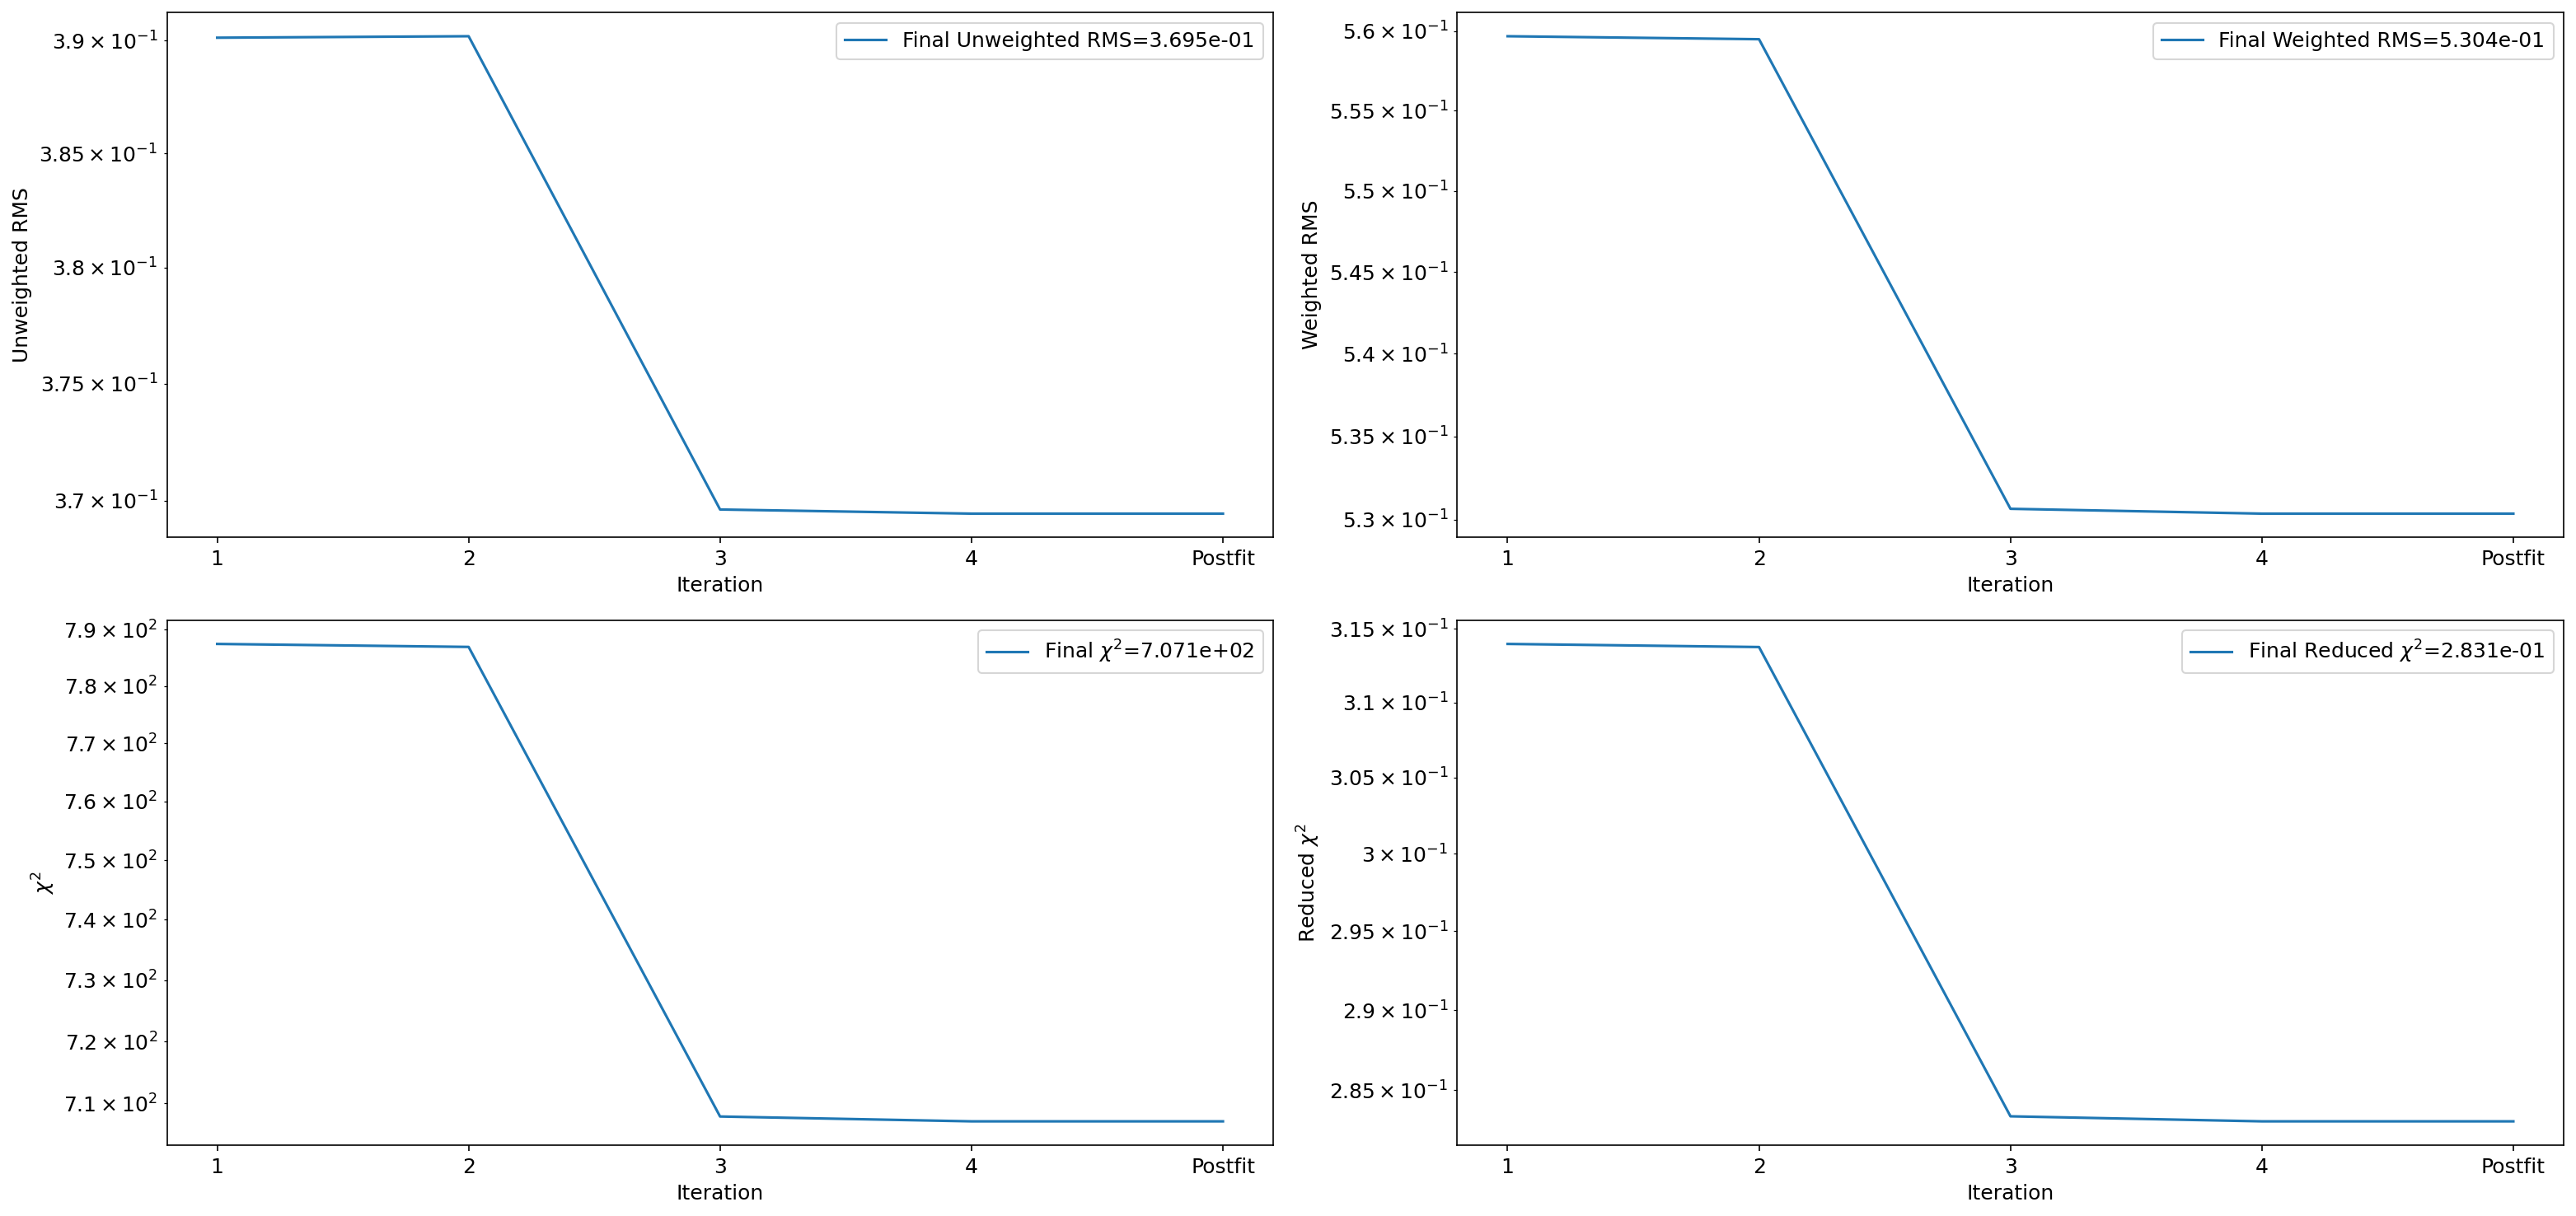

In [7]:
fit_sim.plot_summary(auto_close=True)

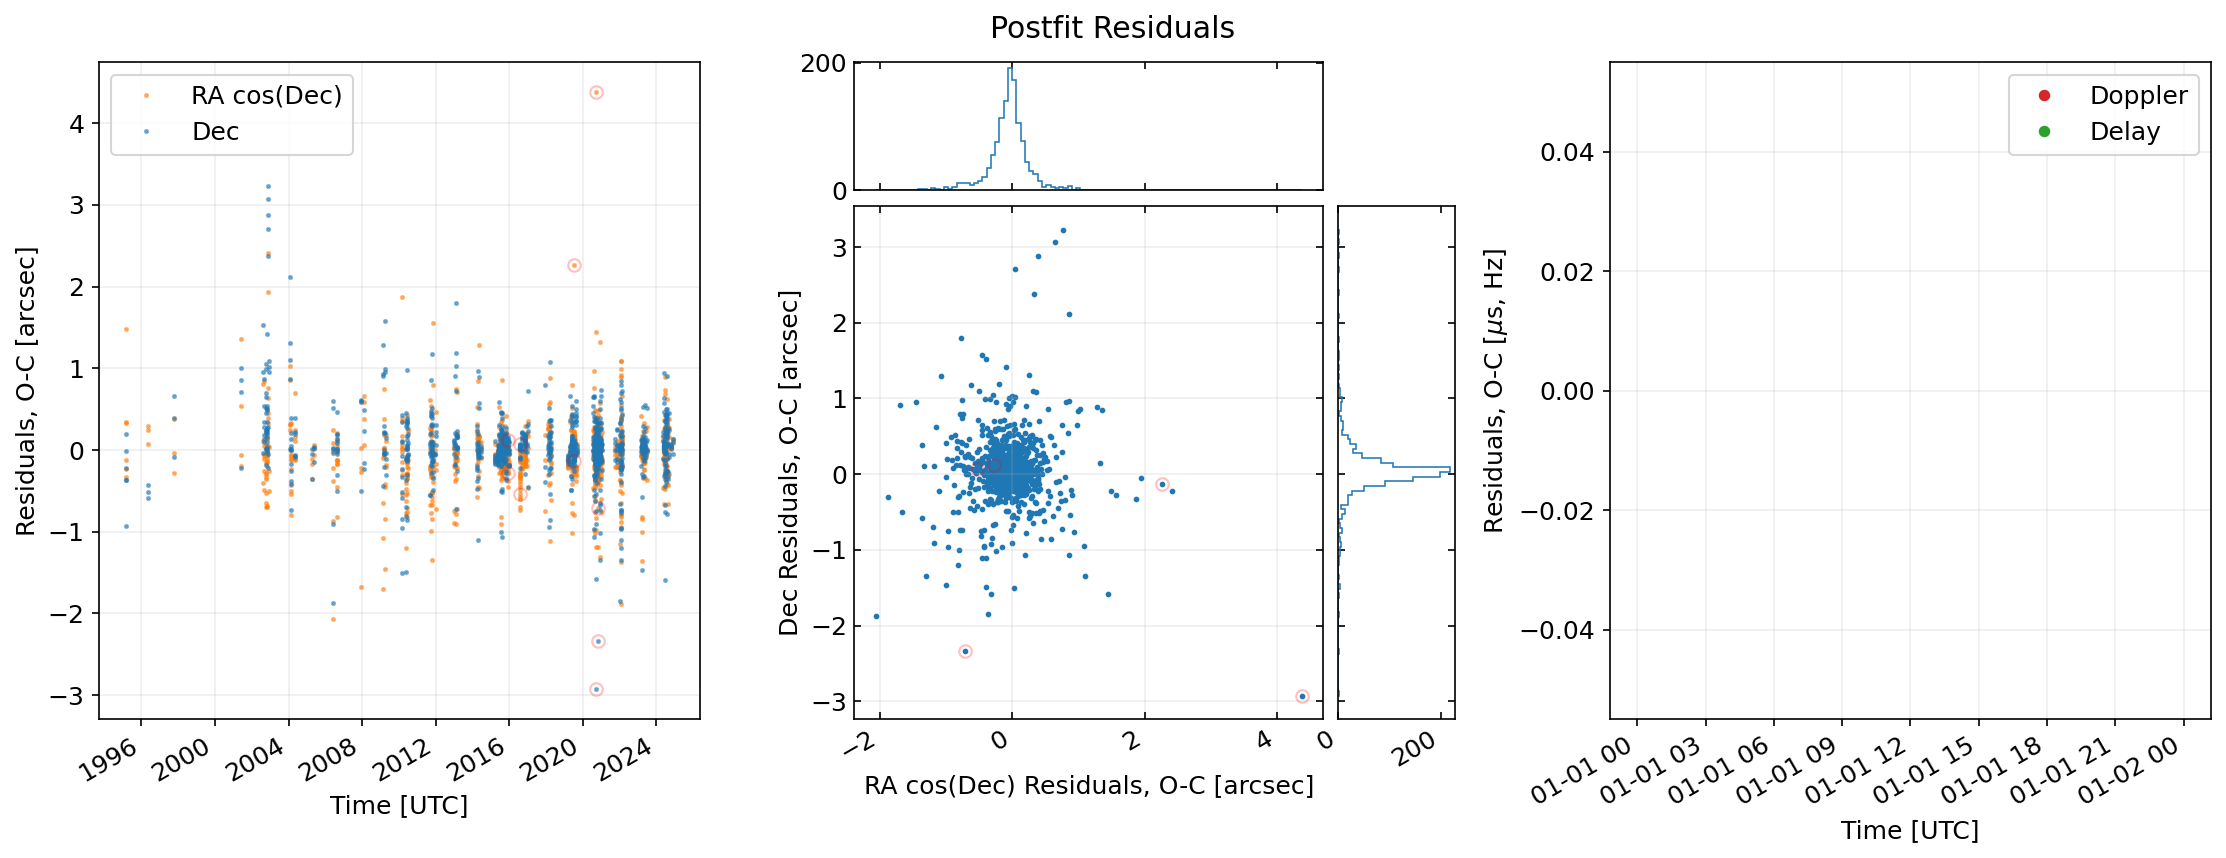

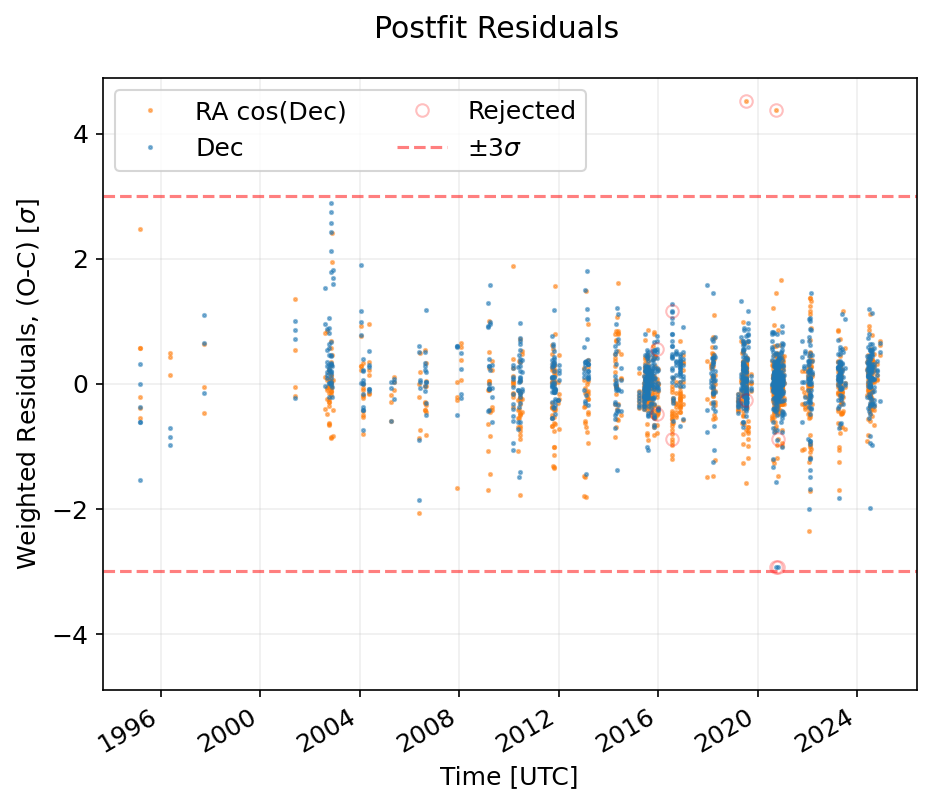

In [8]:
fit_sim.iters[-1].plot_iteration_summary(title='Postfit Residuals', auto_close=True)

In [9]:
mean_0 = np.array(list(init_sol.values())[1:])
cov_0 = init_cov
mean_f = np.array(list(fit_sim.x_nom.values()))
cov_f = fit_sim.covariance

maha_dist_f, maha_dist_0, bhattacharya, bhatt_coeff = fit.get_similarity_stats(mean_0, cov_0, mean_f, cov_f)
print(f'Mahalonobis distance between JPL and GRSS solution: {maha_dist_f:0.2f}')
print(f'Mahalonobis distance between GRSS and JPL solution: {maha_dist_0:0.2f}')
print(f'Bhattacharya distance between JPL and GRSS solution: {bhattacharya:0.4f}')
print(f'Bhattacharya coefficient between JPL and GRSS solution: {bhatt_coeff:0.4f}')

Mahalonobis distance between JPL and GRSS solution: 0.35
Mahalonobis distance between GRSS and JPL solution: 0.34
Bhattacharya distance between JPL and GRSS solution: 0.0003
Bhattacharya coefficient between JPL and GRSS solution: 0.9997


#### Finally, we'll make sure the GRSS solution is statistically consistent with the JPL SBDB solution

In [10]:
assert maha_dist_f < 5.0
assert maha_dist_0 < 5.0
assert bhattacharya < 0.10
assert bhatt_coeff > 0.90